## pulizia file 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
false = pd.read_csv("/home/federica/LAB2/nuovo/uniprot_false.tsv", sep="\t", low_memory=False)
true = pd.read_csv("/home/federica/LAB2/nuovo/uniprot_true.tsv", sep="\t", low_memory=False)

In [3]:
columns_to_keep = ['Entry',	'Reviewed',	'Entry Name','Protein names','Gene Names','Organism','Protein families', 'Natural variant','CDD','DisProt',
                   'Reactome', 'Interacts with','Subunit structure','Gene Names (primary)','Organism (ID)','Gene Names (synonym)','Involvement in disease',
                   'Pharmaceutical use','ChEMBL','DrugBank','BindingDB','DrugCentral', 'Mutagenesis']
true = true[columns_to_keep]
false = false[columns_to_keep]

In [4]:
#Nella colonna "Involvement in disease", usa la parola "DISEASE" come separatore. Se inizia con "Note: " escludi record;
#Il record finisce con la parola " EMIM". Per ogni proteina puoi generare una lista interna a questo campo. 
def process_involvement_in_disease(text):
    if pd.isna(text) or text.startswith("Note: "):
        return None
    diseases = []
    # Trova tutte le occorrenze di DISEASE: <nome della malattia> [MIM:<numero>]
    matches = re.findall(r"DISEASE: (.+?) \[MIM:\d+\]", text)
    for match in matches:
        diseases.append(match.strip())
    return "; ".join(diseases) if diseases else None


In [5]:
true["Involvement in disease"] = true["Involvement in disease"].apply(process_involvement_in_disease)
false["Involvement in disease"] = false["Involvement in disease"].apply(process_involvement_in_disease)

In [6]:
def process_natural_variant(variant_string):
    if not isinstance(variant_string, str):
        return None
    matches = re.findall(r'VARIANT (\d+); /note="(\w) -> (\w) \(in (.+?)\)";', variant_string)
    results = []
    
    for match in matches:
        position = match[0]
        from_aa = match[1]
        to_aa = match[2]
        info = match[3]
        
        # Extract the dbSNP part if present
        dbsnp_match = re.search(r'dbSNP:[^;]+', info)
        if dbsnp_match:
            dbsnp_info = dbsnp_match.group(0)
            info = info.replace(dbsnp_info, '').strip()
        
        # Format the result
        result = f"{from_aa}{position}{to_aa}: {info}"
        results.append(result.strip(': '))
    
    return '-'.join(results)

In [7]:
true["Natural variant"] = true["Natural variant"].apply(process_natural_variant)
false["Natural variant"] = false["Natural variant"].apply(process_natural_variant)

In [8]:
def process_mutagenesis(text):
    if pd.isna(text):
        return None
    mutagenesis_data = []
    pattern = re.compile(r"MUTAGEN (\d+(?:\.\.\d+)?); /note=\"(\w+)->(\w+): (.*?);")
    for match in pattern.finditer(text):
        position = match.group(1)
        original = match.group(2)
        new = match.group(3)
        description = match.group(4)
        mutagenesis_data.append(f"{original}{position}{new}: {description}")
    return "; ".join(mutagenesis_data) if mutagenesis_data else None

In [9]:
true["Mutagenesis"] = true["Mutagenesis"].apply(process_mutagenesis)
false["Mutagenesis"] = false["Mutagenesis"].apply(process_mutagenesis)

In [10]:
true.to_csv("/home/federica/LAB2/nuovo/uniprot_true_processed.tsv", sep="\t", index=False)
false.to_csv("/home/federica/LAB2/nuovo/uniprot_false_processed.tsv", sep="\t", index=False)

## Cluster su EGFR con funzione di BemisMurcko

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors, Descriptors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [12]:
df=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/whole_dataset_out.csv")

In [13]:
def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

In [14]:
df["Scaffold"] = df["Smiles"].apply(get_bemis_murcko_scaffold)

In [15]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.zeros((2048,))

df["Fingerprint"] = df["Smiles"].apply(get_fingerprint)
fp_matrix = np.array(df["Fingerprint"].tolist())

[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerator
[11:56:54] DEPRECATION WARNING: please use MorganGenerat

In [16]:
pca = PCA(n_components=50)
fp_pca = pca.fit_transform(fp_matrix)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(fp_pca)
df["TSNE1"], df["TSNE2"] = tsne_results[:, 0], tsne_results[:, 1]

In [17]:
df["Scaffold"] = df["Scaffold"].apply(lambda x: str(x) if isinstance(x, list) else x)
scaffolds = df["Scaffold"].unique()
color_map = ListedColormap(sns.color_palette("husl", len(scaffolds)))
palette = sns.color_palette(color_map.colors)
scaffold_dict = {scaffold: i for i, scaffold in enumerate(scaffolds)}
df["Scaffold_ID"] = df["Scaffold"].map(scaffold_dict)

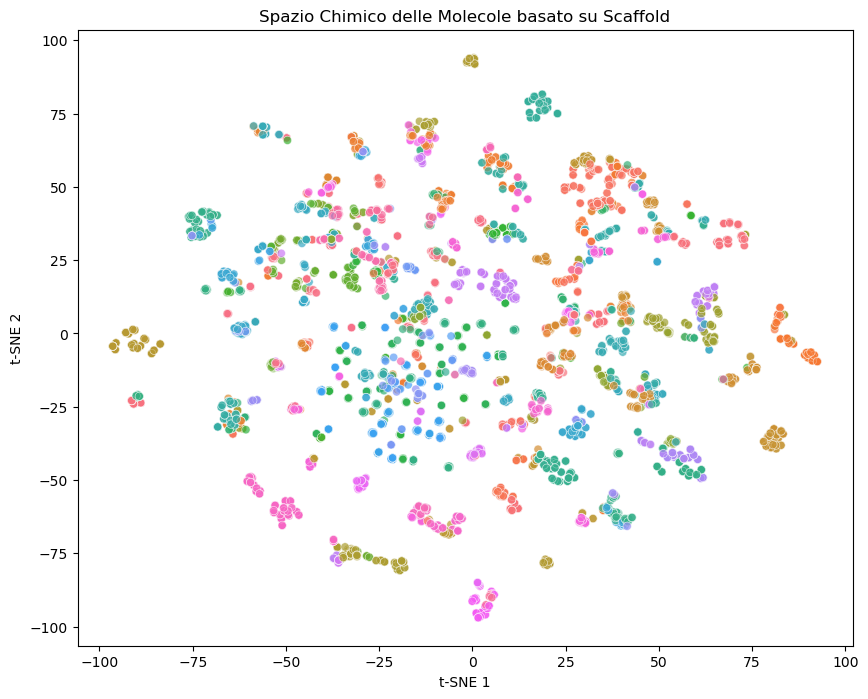

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette=palette, data=df, alpha=0.7, legend=False)
plt.title("Spazio Chimico delle Molecole basato su Scaffold")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [20]:
def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

In [21]:
df["Scaffold"] = df["Smiles"].apply(get_bemis_murcko_scaffold)

In [22]:
scaffold_mapping = {scaf: i for i, scaf in enumerate(df["Scaffold"].unique())}
df["Scaffold Cluster"] = df["Scaffold"].map(scaffold_mapping)

In [ ]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.zeros((2048,))

df["Fingerprint"] = df["Smiles"].apply(get_fingerprint)
fp_matrix = np.array(df["Fingerprint"].tolist())

Errore: Il dataset ha meno di 2 campioni, t-SNE non può essere eseguito.


In [ ]:
def plot_clusters(data):
    plt.figure(figsize=(15, 10))
    sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold Cluster", palette="tab10", data=data, alpha=0.7,legend=False)
    
    # Selezionare solo alcune molecole per l'etichettatura
    labeled_molecules = data.groupby("Molecule Name").first().reset_index()
    
    for i, row in labeled_molecules.iterrows():
        plt.text(row["TSNE1"], row["TSNE2"], row["Molecule Name"], fontsize=8, alpha=0.7)
    
    plt.title("Chemical Space Clustering via Bemis-Murcko Scaffolds")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.show()

plot_clusters(df)


In [ ]:
def plot_clusters(data, highlight="OSIMERTINIB"):
    plt.figure(figsize=(12, 8))
    osimertinib_cluster = data[data["Molecule Name"].str.contains(highlight, case=False, na=False)]["Scaffold"].unique()
    sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette="tab10", data=data, alpha=0.7, legend=False)
    if len(osimertinib_cluster) > 0:
        cluster_data = data[data["Scaffold"].isin(osimertinib_cluster)]
        sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette="tab10", data=cluster_data, alpha=0.9, legend=True)
    osimertinib_points = data[data["Molecule Name"].str.contains(highlight, case=False, na=False)]
    for _, row in osimertinib_points.iterrows():
        plt.text(row["TSNE1"], row["TSNE2"], row["Molecule Name"], fontsize=10, color="red")
        plt.scatter(row["TSNE1"], row["TSNE2"], color="red", edgecolors="black", s=100, linewidth=2, alpha=0.9)

    plt.title("Chemical Space Clustering via Bemis-Murcko Scaffolds")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.legend(title="Scaffold Cluster", bbox_to_anchor=(1, 1))
    plt.show()

plot_clusters(df, highlight="OSIMERTINIB")



In [ ]:
osimertinib_scaffold = df[df["Molecule Name"].str.contains("osimertinib", case=False, na=False)]["Scaffold"].unique()
print(osimertinib_scaffold)